## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a portion of Haiti Tree Project (THTP) captures verified by Cam.

### Dependencies

In [28]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
import time
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark = True

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://github.com/Greenstand/Tree_Species/tree/master/training)).

In [13]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.13.29.55_18.29298411961645_-73.5581...,https://treetracker-production-images.s3.eu-ce...


In [14]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data.apply(image_saver, axis=1)


0      (/home/ec2-user/SageMaker/treetracker-machine-...
1      (/home/ec2-user/SageMaker/treetracker-machine-...
2      (/home/ec2-user/SageMaker/treetracker-machine-...
3      (/home/ec2-user/SageMaker/treetracker-machine-...
4      (/home/ec2-user/SageMaker/treetracker-machine-...
                             ...                        
383    (/home/ec2-user/SageMaker/treetracker-machine-...
384    (/home/ec2-user/SageMaker/treetracker-machine-...
385    (/home/ec2-user/SageMaker/treetracker-machine-...
386    (/home/ec2-user/SageMaker/treetracker-machine-...
387    (/home/ec2-user/SageMaker/treetracker-machine-...
Length: 388, dtype: object

388  total samples
Class breakdown
          imname  url
class                
ACACAURI     111  111
ANACOCCI      53   53
CATALONG      75   75
MANGINDI     149  149
4  classes found


Text(0.5, 1.0, 'Count per class')

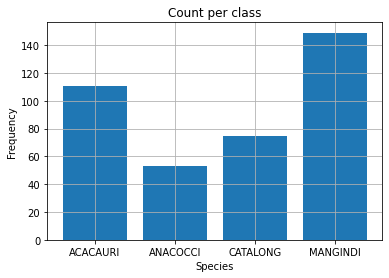

In [15]:
print (data.shape[0], " total samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
print (count_by_class)
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [16]:
arrs = []
labels = []
for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((224, 224)))
            labels.append(species)
            


In [17]:
X = np.vstack([np.asarray(img).flatten() for img in arrs])
X_embedded = TSNE(n_components=2, perplexity=30.0, learning_rate=25.0, n_iter=10000).fit_transform(X)

In [18]:
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [19]:
print (tsne_result.head(5))

         x0        x1     class  Color
0  1.275012  1.233589  ACACAURI    0.0
1  0.979502 -2.494604  ACACAURI    0.0
2  0.162467  1.123958  ACACAURI    0.0
3 -0.973389 -0.422812  ACACAURI    0.0
4  0.853858 -0.558673  ACACAURI    0.0


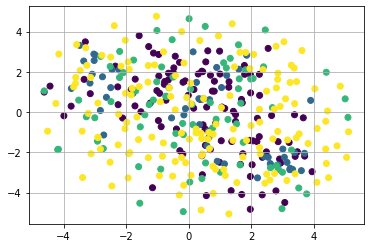

In [20]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"])


In [22]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

transform = T.Compose([T.Resize(512), T.CenterCrop(299), T.ToTensor()])

inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)
criterion = torch.nn.CrossEntropyLoss()
inception = inception.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

cuda:0


In [24]:
preds = [inception(transform(img)[None, ...].to(device)).detach().numpy() for img in arrs]

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 768, 1, 1])

In [ ]:
print (data.head(5))

In [25]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(list(self.data["class"].unique()), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.loadpath, self.data.iloc[idx, :]["class"], self.data.iloc[idx, :]["imname"])
        label = self.data.iloc[idx, :]["class"]
        img = self.transform(Image.open(img_path))
        label = self.numerical_encoding[label]
        return img, label
        
        

In [33]:
val_split = 0.5
idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, transform, None)
val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, transform, None)

tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=2, pin_memory=True)

num_epochs = 20

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0
    start = time.time()
    tr_acc_sum = 0
    samples = 0
    for batch_x, batch_y in tr_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = inception.forward(batch_x)
        loss = criterion(output.logits, batch_y)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        tr_acc_sum += torch.sum(torch.argmax(output.logits, dim=1) == batch_y)
        samples += batch_y.size()[0]
    with torch.no_grad():
        val_samples = 0
        for val_x, val_y in val_dataloader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_output = inception.forward(val_x)
            val_loss = criterion(val_output.logits, val_y)
            val_acc = torch.sum(torch.argmax(val_output.logits, dim=1) == val_y) / val_x.shape[0]
            val_samples += val_y.size()[0]
    print ("Epoch %d finished in %f seconds"%(epoch + 1, time.time() - start))
    print ("Training/Validation Loss: (%f, %f)"%(running_loss, val_loss))
    print ("Training/Validation Accuracy: (%f, %f)"%(acc_sum / samples, val_acc / val_samples))
    print ("=" * 40)
print ("Finished training")

Epoch 19 finished in 11.240549 seconds
Training/Validation Loss: (31.631072, 2.544781)
Training/Validation Accuracy: (1.587629, 0.002258)
Epoch 20 finished in 11.130580 seconds
Training/Validation Loss: (19.351484, 2.671845)
Training/Validation Accuracy: (1.587629, 0.002418)
Finished training
